In this notebook, we have loaded both train and test dataset and filled the missing values.

for Education we used "Missing" to fill

for previous_year_rating we used -1 to fill the values for both train and test data set.

Also previous_year rating must be related to length of years of service. for those employees where lenght of service is 1, those people should not be having the previous year rating. so this would be the critical feature to determine the promotion.

obviously people having no experience can not be promoted.

region is converted in to codes as that contains 34 unique values and creating 34 one hot encoded values does not make sense. but this can be tried out as it is possible that promotion are based on region wise.

Department we will one hot encode as its common basic people working in HR will be promoted in same department.

Region is having almost similar distribution in both training and test set.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [6]:
df_train = pd.read_csv(r'C:\Users\GJ\Desktop\Machine Learning\fastai\WNS\train.csv', low_memory=False)
#df_test = pd.read_csv(r'C:\Users\GJ\Desktop\Machine Learning\fastai\WNS\test.csv', low_memory=False)

In [7]:
df_test = pd.read_csv(r'C:\Users\GJ\Desktop\Machine Learning\fastai\WNS\results.csv', low_memory=False)

In [8]:
def display_all(df) : 
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [9]:
df_train.education.fillna(value="Missing", inplace=True)

In [10]:
df_test.education.fillna(value="Missing", inplace=True)

In [11]:
df_train.previous_year_rating.fillna(value=3.0, inplace=True)
df_test.previous_year_rating.fillna(value=3.0, inplace=True)

In [12]:
df_train.previous_year_rating = df_train.previous_year_rating.astype('category')
df_test.previous_year_rating = df_test.previous_year_rating.astype('category')

In [13]:
df_train['region'] = df_train.region.astype('category').cat.as_ordered()

In [14]:
df_train.region.cat.set_categories(['region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9', 'region_10', 'region_11', 'region_12', 'region_13', 'region_14', 'region_15', 'region_16', 'region_17', 'region_18', 'region_19', 'region_20', 'region_21', 'region_22', 'region_23', 'region_24', 'region_25', 'region_26', 'region_27', 'region_28', 'region_29', 'region_30', 'region_31', 'region_32', 'region_33', 'region_34'],
                                   ordered=True, inplace=True)

In [15]:
df_train.region.head()

0     region_7
1    region_22
2    region_19
3    region_23
4    region_26
Name: region, dtype: category
Categories (34, object): [region_1 < region_2 < region_3 < region_4 ... region_31 < region_32 < region_33 < region_34]

In [16]:
df_test['region'] = pd.Categorical(df_test['region'], categories=df_train['region'].cat.categories, ordered=True)

In [17]:
df_train['gender'] = df_train.gender.astype('category').cat.as_ordered()

In [18]:
df_test['gender'] = pd.Categorical(df_test['gender'], categories=df_train['gender'].cat.categories, ordered=True)

In [19]:
df_train['gender'] = df_train.gender.cat.codes
df_test['gender'] = df_test.gender.cat.codes

In [20]:
df_train['region'] = df_train.region.cat.codes
df_test['region'] = df_test.region.cat.codes

Getting dummies for categorical variables. Also here we are treating rating as categorical variable since it has missing vallues which seems to be related to employees who are 1 year experienced.

In [21]:
df_train = pd.concat([df_train.drop('department', axis=1), pd.get_dummies(df_train.department, prefix='department')], axis=1)

In [22]:
df_test = pd.concat([df_test.drop('department', axis=1), pd.get_dummies(df_test.department, prefix='department')], axis=1)

In [23]:
df_train = pd.concat([df_train.drop('education', axis=1), pd.get_dummies(df_train.education, prefix='education')], axis=1)

In [24]:
df_test = pd.concat([df_test.drop('education', axis=1), pd.get_dummies(df_test.education, prefix='education')], axis=1)

In [25]:
df_train = pd.concat([df_train.drop('recruitment_channel', axis=1), pd.get_dummies(df_train.recruitment_channel, prefix='recruitment_channel')], axis=1)

In [26]:
df_test = pd.concat([df_test.drop('recruitment_channel', axis=1), pd.get_dummies(df_test.recruitment_channel, prefix='recruitment_channel')], axis=1)

In [27]:
df_train = pd.concat([df_train.drop('previous_year_rating', axis=1), pd.get_dummies(df_train.previous_year_rating, prefix='previous_year_rating')], axis=1)

In [28]:
df_test = pd.concat([df_test.drop('previous_year_rating', axis=1), pd.get_dummies(df_test.previous_year_rating, prefix='previous_year_rating')], axis=1)

# One hot encoded data
Saving the dataset in dataframe format after performing one hot encoding.

In [29]:
df_train.is_promoted.value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

# removed gender and age and it has really improved the model score.

In [30]:
df_train_v1 = df_train.drop(columns='gender', axis=1)
df_train_v1 = df_train_v1.drop(columns='age', axis=1)

In [31]:
len(df_train_v1.columns)

29

In [32]:
df_test_v1 = df_test.drop(columns='gender', axis=1)
df_test_v1 = df_test_v1.drop(columns='age', axis=1)

Rating with bins is working better as compared to treat it as continous variable.

Binning of average training score did not work out. let's focus on region feature.

Took the log of avg_training_score but it did not help. model performance is still the same.

### removed region which helped to improve the score quite a bit.

In [33]:
df_train_v1.avg_training_score = np.log(df_train_v1.avg_training_score)
df_test_v1.avg_training_score = np.log(df_test_v1.avg_training_score)

In [34]:
df_train_v1.drop(columns='region', axis=1, inplace=True)
df_test_v1.drop(columns='region', axis=1, inplace=True)

In [35]:
df_train_v1.drop(columns=['recruitment_channel_other', 'recruitment_channel_referred', 'recruitment_channel_sourcing'],
                axis=1, inplace=True)

In [36]:
df_test_v1.drop(columns=['recruitment_channel_other', 'recruitment_channel_referred', 'recruitment_channel_sourcing'],
                axis=1, inplace=True)

In [ ]:
df_train_v1.head().T

### Removed columns gender, age, region and recruitment channel as these factors should not contribute to decide if promotion should be given or not.

# Normalizing the variables

In [38]:
no_trng_min = df_train_v1.no_of_trainings.min()
no_trng_max = df_train_v1.no_of_trainings.max()
avg_trng_score_mean = df_train_v1.avg_training_score.mean()
avg_trng_score_std = df_train_v1.avg_training_score.std()
length_service_min = df_train_v1.length_of_service.min()
length_service_max = df_train_v1.length_of_service.max()

In [39]:
df_train_v1.no_of_trainings = (df_train_v1.no_of_trainings - no_trng_min)/(no_trng_max)
df_test_v1.no_of_trainings = (df_test_v1.no_of_trainings - no_trng_min)/(no_trng_max)

In [40]:
df_train_v1.avg_training_score = (df_train_v1.avg_training_score - avg_trng_score_mean)/(avg_trng_score_std)
df_test_v1.avg_training_score = (df_test_v1.avg_training_score - avg_trng_score_mean)/(avg_trng_score_std)

In [41]:
df_train_v1.length_of_service = (df_train_v1.length_of_service - length_service_min)/(length_service_max)
df_test_v1.length_of_service = (df_test_v1.length_of_service - length_service_min)/(length_service_max)

In [42]:
df_train_v1.head()

,employee_id,no_of_trainings,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Analytics,department_Finance,department_HR,...,department_Technology,education_Bachelor's,education_Below Secondary,education_Master's & above,education_Missing,previous_year_rating_1.0,previous_year_rating_2.0,previous_year_rating_3.0,previous_year_rating_4.0,previous_year_rating_5.0
0,65438,0.0,0.189189,1,0,-1.137576,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,65141,0.0,0.081081,0,0,-0.160248,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,7513,0.0,0.162162,0,0,-1.040083,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,2542,0.1,0.243243,0,0,-1.040083,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,48945,0.0,0.027027,0,0,0.786150,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0


In [43]:
#os.makedirs('tmp', exist_ok=True)
df_train_v1.to_feather(r'tmp\train_v6')
df_test_v1.to_feather(r'tmp\test_v6')

## Till above we have same steps like basic processsing V2 apart from reading the df_test_v1 which is reading predicted test set containing psuedo labels.

Below part contains the creation of dataset in which we took all rows containing values 1 and 4000 random rows from values 0.

In [46]:
df_pseudo_1 = df_test_v1[df_test_v1.is_promoted==1]
df_pseudo_0 = df_test_v1[df_test_v1.is_promoted==0]
df_pseudo_sample = get_sample(df_pseudo_0, 4000)

In [47]:
df_pseudo = pd.concat([df_pseudo_sample, df_pseudo_1], axis=0)

In [54]:
df_train_final = pd.concat([df_train_v1, df_pseudo], axis=0)
len(df_train_final)

59569

In [56]:
df_train_final.reset_index(drop=True, inplace=True)

In [57]:
df_train_final.to_feather(r'tmp\train_Psuedo')

In [40]:
#os.makedirs('tmp', exist_ok=True)
df_train_v1.to_feather(r'tmp\train_v3')
df_test_v1.to_feather(r'tmp\test_v3')

In [44]:
len(df_test_v1.columns), len(df_train_v1.columns)

(17, 18)

In [32]:
df_train_v1 = pd.read_feather(r'tmp\train_v3')
df_test_v1 = pd.read_feather(r'tmp\test_v3')

In [33]:
n_valid = 10000
n_trn = len(df_train_v1) - n_valid
n_trn, n_valid

(44808, 10000)

In [34]:
def split_vals(a,n) : return a[:n].copy(), a[n:].copy()

In [35]:
df_train_v2, df_valid = split_vals(df_train_v1, n_trn)

let's try upsample minority class here

In [36]:
df_majority = df_train_v2[df_train_v2.is_promoted==0]
df_minority = df_train_v2[df_train_v2.is_promoted==1]

In [40]:
len(df_majority), len(df_minority)

(40998, 3810)

In [42]:
df_majority_1 = df_majority[:10000]
df_majority_2 = df_majority[10000:20000]
df_majority_3 = df_majority[20000:30000]
df_majority_4 = df_majority[30000:]

In [43]:
df_train_1 = pd.concat([df_majority_1, df_minority], axis=0)
df_train_2 = pd.concat([df_majority_2, df_minority], axis=0)
df_train_3 = pd.concat([df_majority_3, df_minority], axis=0)
df_train_4 = pd.concat([df_majority_4, df_minority], axis=0)

In [45]:
df_train_merged = pd.concat([df_train_1, df_train_2, df_train_3, df_train_4], axis=0)

In [44]:
df_train_1.reset_index(drop = True, inplace = True)
df_train_2.reset_index(drop = True, inplace = True)
df_train_3.reset_index(drop = True, inplace = True)
df_train_4.reset_index(drop = True, inplace = True)

In [46]:
df_train_merged.reset_index(drop=True, inplace=True)

In [48]:
df_train_merged.to_feather(r'tmp\train_v5')

In [50]:
df_valid.reset_index(drop=True, inplace=True)

In [51]:
df_valid.to_feather(r'tmp\valid_v5')

In [31]:
#os.makedirs('tmp', exist_ok=True)
df_train_1.to_feather(r'tmp\train_v4_1')
df_train_2.to_feather(r'tmp\train_v4_2')
df_train_3.to_feather(r'tmp\train_v4_3')
df_train_4.to_feather(r'tmp\train_v4_4')
df_train_5.to_feather(r'tmp\train_v4_5')

In [67]:
from imblearn.over_sampling import SMOTE

In [61]:
b = df_train_v1[df_train_v1.is_promoted==0]

In [58]:
a = df_train_v1[df_train_v1.is_promoted==1]

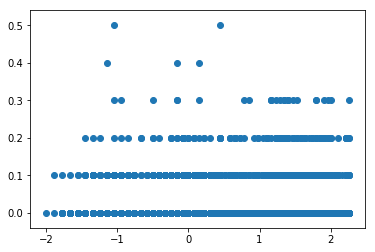

In [59]:
plt.scatter(a.avg_training_score,a.no_of_trainings)

(array([  3.,  17.,  67., 175., 315., 116.,  96., 281., 283., 357., 199., 247., 317., 182., 284., 420., 472.,
        329., 295., 213.]),
 array([-1.99775, -1.78505, -1.57234, -1.35964, -1.14693, -0.93423, -0.72152, -0.50881, -0.29611, -0.0834 ,
         0.1293 ,  0.34201,  0.55471,  0.76742,  0.98013,  1.19283,  1.40554,  1.61824,  1.83095,  2.04365,
         2.25636]),
 <a list of 20 Patch objects>)

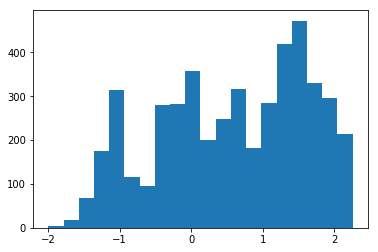

In [60]:
plt.hist(a.avg_training_score, bins=20)

(array([   7.,   85.,  494., 1750., 4008., 7429., 3064., 1773., 4124., 5669., 2887., 1061., 3366., 1893.,
        1182., 3639., 3575., 3378.,  726.,   30.]),
 array([-2.23909, -2.02174, -1.8044 , -1.58705, -1.3697 , -1.15235, -0.935  , -0.71766, -0.50031, -0.28296,
        -0.06561,  0.15173,  0.36908,  0.58643,  0.80378,  1.02112,  1.23847,  1.45582,  1.67317,  1.89052,
         2.10786]),
 <a list of 20 Patch objects>)

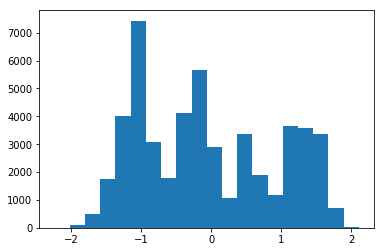

In [62]:
plt.hist(b.avg_training_score, bins=20)

(array([   4.,   27.,  229.,  823., 3015., 2250., 1766.,  785., 2299., 2289., 1006.,  895., 1333.,  707.,
        1096., 2123., 1926.,  680.,  138.,   99.]),
 array([-2.23909, -2.01432, -1.78955, -1.56477, -1.34   , -1.11523, -0.89046, -0.66568, -0.44091, -0.21614,
         0.00863,  0.23341,  0.45818,  0.68295,  0.90772,  1.1325 ,  1.35727,  1.58204,  1.80681,  2.03159,
         2.25636]),
 <a list of 20 Patch objects>)

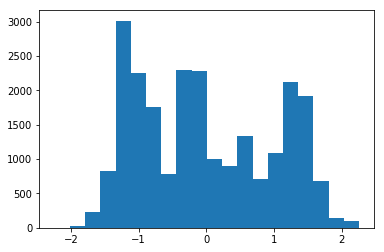

In [64]:
plt.hist(df_test_v1.avg_training_score, bins=20)

(array([   7.,   88.,  511., 1817., 6864., 5063., 4177., 1942., 5399., 5484., 2328., 2243., 2971., 1681.,
        2549., 5170., 4350., 1585.,  365.,  214.]),
 array([-2.23909, -2.01432, -1.78955, -1.56477, -1.34   , -1.11523, -0.89046, -0.66568, -0.44091, -0.21614,
         0.00863,  0.23341,  0.45818,  0.68295,  0.90772,  1.1325 ,  1.35727,  1.58204,  1.80681,  2.03159,
         2.25636]),
 <a list of 20 Patch objects>)

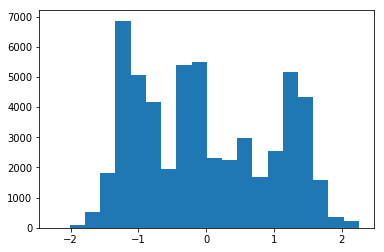

In [65]:
plt.hist(df_train_v1.avg_training_score, bins=20)

In [ ]:
a['previous_year_rating_5.0'].value_counts()

In [ ]:
b['previous_year_rating_5.0'].value_counts()

In [261]:
a['group'] = pd.cut(a.avg_training_score.values,bins=[38,50,55,60,65,70,75,80,85,90,95,100],
                   labels=["38to50","50to55","55to60","60to65","65to70","70to75","75to80","80to85","85to90","90to95","95to100"])

In [291]:
df_train_rating = pd.read_csv(r'C:\Users\GJ\Desktop\Machine Learning\fastai\WNS\train.csv', low_memory=False)
df_test_rating = pd.read_csv(r'C:\Users\GJ\Desktop\Machine Learning\fastai\WNS\test.csv', low_memory=False)